In [85]:
from prep_financial_phrasebank import (
    tokenize_financial_phrasebank,
    generate_data_word2vec,
    sum_token_embeddings,
    run_experiment,
    RNN_experiment_torch,
)
import nltk
import pandas as pd
import random
import numpy as np
from nltk.sentiment import vader
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
afin = Afinn()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adlerviton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adlerviton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adlerviton/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1: Set up

In [86]:
# Initialize VADER
sia = vader.SentimentIntensityAnalyzer()

In [87]:
# make a vocabulary from the lexicon which excludes non alpha tokens
vocab = sorted([token for token in sia.lexicon if token.isalpha()])

In [88]:
import gensim.downloader as api

google_news = api.load("word2vec-google-news-300")

In [89]:
from prep_financial_phrasebank import clean_text

# 2: Create Vader Synthetic Data (random words from NLTK vader lexicon)

### a. Get random sentences from lexicon

In [90]:
def create_synth_data(num):
    columns = ["sentence", "label"]
    synthetic_df = pd.DataFrame(columns=columns)
    for i in range(num):
        max_length = 8
        length = int(np.round(np.random.uniform(0.15, 1) * max_length))
        rand_text = [random.choice(vocab) for _ in range(length)]
        random_text = " ".join(rand_text)
        sent = sum(sia.lexicon[word] for word in rand_text) / len(rand_text)
        synthetic_df.loc[i] = [random_text, sent]  # Add rand_text to synthetic_df

    synthetic_df["label"] = np.where(
        synthetic_df["label"] < -0.58, 0, np.where(synthetic_df["label"] > 0.18, 2, 1)
    )

    return synthetic_df

### b. Get sentiment value for each word from vader sentiment analyzer, then average.

### c. labels are thresholded as follows, creating relatively balanced data:
```
        avg < -0.58 becomes 0
-0.58 < avg < 0.18  becomes 1
0.18  < avg         becomes 2
```

### d. look at label distribution of fake data after thresholding

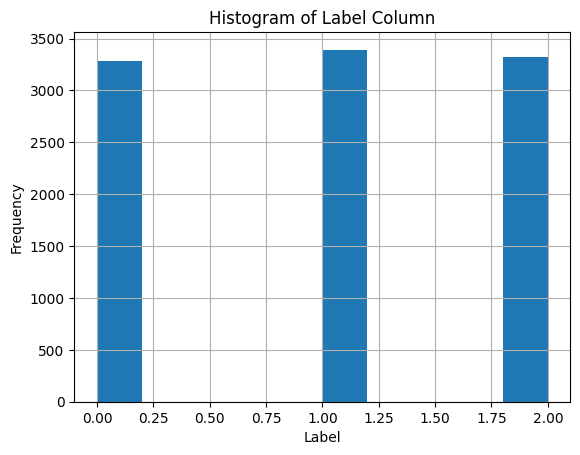

In [91]:
import matplotlib.pyplot as plt
import numpy as np

synthetic_df = create_synth_data(10000)


synthetic_df["label"].hist()

# Add labels and title
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Histogram of Label Column")

# Display the histogram
plt.show()

# 3: Create 2 1D Afinn models

In [92]:
def sum_vader_scores(sentence):
    sent_score = np.sum(np.array([afin.score(word) for word in sentence]))
    return sent_score


def generate_X_vader(df):
    X = np.array([sum_vader_scores(sentence) for sentence in df["text"]])
    return X.reshape(-1, 1)


def generate_y_vader(df):
    y = np.array(df.label).reshape(-1, 1)
    return y

### a. Train afinn Logistic Regression Model

In [93]:
columns = ["text", "label"]
synthetic_df_clean = pd.DataFrame(columns=columns)
synthetic_df_clean["label"] = synthetic_df["label"]
synthetic_df_clean["text"] = synthetic_df["sentence"].apply(clean_text)
# remove empty strings
synthetic_df_clean = synthetic_df_clean[synthetic_df_clean["text"] != ""]


X_single = generate_X_vader(synthetic_df_clean)
y_single = generate_y_vader(synthetic_df_clean)
X_train, X_test, y_train, y_test = train_test_split(
    X_single, y_single, test_size=0.2, random_state=42
)

clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### b. Train afinn RNN model

In [94]:
import torch
from torch import nn
from torch.optim import Adam

X_train, X_test, y_train, y_test = train_test_split(
    X_single, y_single, test_size=0.2, random_state=42
)


class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()

# Reshape X_train to be (batch_size, sequence_length, input_size)
X_train_torch = X_train_torch.view(-1, 1, 1)

# Initialize the model, loss function, and optimizer
model = SimpleRNN(hidden_size=10)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    # print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [95]:
# Convert numpy arrays to PyTorch tensors
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()

# Reshape X_test to be (batch_size, sequence_length, input_size)
X_test_torch = X_test_torch.view(-1, 1, 1)
X_train_torch = X_train_torch.view(-1, 1, 1)

# Switch model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    predictions_test = model(X_test_torch)
    predictions_train = model(X_train_torch)

# Calculate the loss
loss = criterion(predictions_test, y_test_torch)
print(f"Test Loss: {loss.item()}")

# Convert the model's output to binary labels
predicted_test_labels = torch.round(predictions_test)

# Calculate the number of correct predictions
correct_test_predictions = (predicted_test_labels == y_test_torch).float().sum()

# Calculate the accuracy
accuracy_test = correct_test_predictions / y_test_torch.shape[0]

# Convert the model's output to binary labels
predicted_train_labels = torch.round(predictions_train)

# Calculate the number of correct predictions
correct_train_predictions = (predicted_train_labels == y_train_torch).float().sum()

# Calculate the accuracy
accuracy_train = correct_train_predictions / y_train_torch.shape[0]

Test Loss: 0.6552258729934692


### c. Get Results for both

In [96]:
print("afinn Logistic Regression (train):", clf.score(X_train, y_train))
print("afinn Logistic Regression (test):", clf.score(X_test, y_test))
print(f"afinn RNN (train)): {accuracy_train.item()}")
print(f"afinn RNN (test)): {accuracy_test.item()}")

afinn Logistic Regression (train): 0.337875
afinn Logistic Regression (test): 0.345
afinn RNN (train)): 0.33787500858306885
afinn RNN (test)): 0.3449999988079071


# 4. Train 2 Word2Vec Models

### a. Train Word2Vec Logistic Regression

In [97]:
def aggregate_fake_splits(fakedata):
    """
    Aggregate all splits of financial_phrasebank
    """
    df = fakedata
    df = tokenize_financial_phrasebank(df)
    X_train, y_train, X_test, y_test = generate_data_word2vec(df)
    return X_train, y_train, X_test, y_test


def run_experiment1(synthetic_df) -> None:
    from sklearn.linear_model import LogisticRegression

    # prepare training and testing data
    X_train, y_train, X_test, y_test = aggregate_fake_splits(synthetic_df)

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    print("word2vec (train):", clf.score(X_train, y_train))
    print("word2vec (test):", clf.score(X_test, y_test))

    return clf

In [98]:
def generate_X_word2vec(df):
    X = np.array(
        [
            # sum the token embeddings for each sentence. If word is not in the model, return embedding of ['UNK']
            sum_token_embeddings(
                [
                    google_news[word] if word in google_news else google_news["UNK"]
                    for _, word in enumerate(sentence)
                ]
            )
            for _, sentence in enumerate(df.text)
        ]
    )
    return X

In [99]:
def create_labels_clf(synthetic_df):
    clf = run_experiment1(synthetic_df)
    columns = ["text", "label"]
    new_df = pd.DataFrame(columns=columns)
    new_df["text"] = synthetic_df["sentence"]
    new_df["label"] = synthetic_df["label"]
    X = generate_X_word2vec(new_df)
    new_df["predicted"] = clf.predict(X)
    return new_df

### b. Train Word2Vec RNN model

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn import metrics


def RNN_experiment_torch_synth(synthetic_df):
    # prepare training and testing data
    # X_train, y_train, X_test, y_test = aggregate_all_splits()
    X_train, y_train, X_test, y_test = aggregate_fake_splits(synthetic_df)

    # convert to torch tensors
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test)

    # create dataset
    class FinancialPhraseBankDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # create dataloader
    train_dataset = FinancialPhraseBankDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # define model
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(300, 300)
            self.fc2 = nn.Linear(300, 3)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    net = Net()

    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # train
    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            # print(outputs.shape)
            # print(labels.shape)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # if i % 100 == 99:  # print every 100 mini-batches
            # print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))

    # print("Finished Training")
    # After training, generate predictions on test data
    X_test = X_test.float()
    outputs_test = net(X_test)
    _, predicted_test = torch.max(outputs_test, 1)
    outputs_train = net(X_train)
    _, predicted_train = torch.max(outputs_train, 1)
    # Convert tensors to numpy arrays for comparison with sklearn metrics
    y_test_np = y_test.numpy()
    predicted_test_np = predicted_test.numpy()

    # Convert tensors to numpy arrays for comparison with sklearn metrics
    y_train_np = y_train.numpy()
    predicted_train_np = predicted_train.numpy()

    # Now you can use sklearn's metrics to compare y_test_np and predicted_np
    # For example, to calculate accuracy:
    accuracy1 = metrics.accuracy_score(y_train_np, predicted_train_np)
    print("RNN (train): ", accuracy1)
    accuracy2 = metrics.accuracy_score(y_test_np, predicted_test_np)
    print("RNN (test): ", accuracy2)
    return net

# See Results

In [101]:
new_df = create_labels_clf(synthetic_df)

word2vec (train): 0.433375
word2vec (test): 0.4305


In [102]:
totals = new_df.groupby(["label", "predicted"]).size().reset_index(name="count")
print(totals)

   label  predicted  count
0      0          0   1433
1      0          1    940
2      0          2    909
3      1          0    929
4      1          1   1443
5      1          2   1021
6      2          0    863
7      2          1   1012
8      2          2   1450


In [103]:
rnn = RNN_experiment_torch_synth(synthetic_df)

RNN (train):  0.423125
RNN (test):  0.3985


# Try Logistic Regression Model trained on Real News Data

In [104]:
columns = ["text", "label"]
new_df = pd.DataFrame(columns=columns)
clf = run_experiment()
for i in range(2000):
    max_length = 8
    length = int(np.round(np.random.uniform(0.15, 1) * max_length))
    rand_text = [random.choice(vocab) for _ in range(length)]
    random_text = " ".join(rand_text)
    sent = sum(sia.lexicon[word] for word in rand_text) / len(rand_text)
    new_df.loc[i] = [random_text, sent]  # Add rand_text to synthetic_df
new_df["label"] = np.where(
    new_df["label"] < -0.58, 0, np.where(new_df["label"] > 0.18, 2, 1)
)
X = generate_X_word2vec(new_df)
new_df["predicted"] = clf.predict(X)

/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


word2vec (train): 0.6497758226884358
word2vec (test): 0.6477157360406092


## Note that it pretty much predicts neutral for every sentence:

In [105]:
totals = new_df.groupby(["label", "predicted"]).size().reset_index(name="count")
print(totals)

   label  predicted  count
0      0          0      3
1      0          1    672
2      0          2      3
3      1          0      2
4      1          1    662
5      1          2      3
6      2          0      3
7      2          1    648
8      2          2      4
